# SageMaker Ground Truth and Object Detection
## Workshop Guide

### Table of contents
1. [Introduction to dataset](#introduction)
2. [Labeling with SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Model Deployment](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)


<a name="introduction"></a>
## Introduction to dataset
In this workshop we will use a dataset from the [inaturalist.org](inaturalist.org) This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 

The dataset has already been downloaded and unzipped inside the notebook. The archive contains the following structure: 500 `.jpg` image files, a manifest file (to be explained later) and 10 test images in the `test_images` subfolder.

Now let's upload this dataset to your own S3 bucket in preparation for labeling and training using Amazon SageMaker. We will make sure that the S3 bucket is created then synchronize the dataset and copy it across to the bucket

## Import Sagemaker SDK and use the default S3 Bucket

In [ ]:
import sagemaker
# S3 bucket must be created in the current region
BUCKET = sagemaker.Session().default_bucket()
sagemaker.session.ShuffleConfig(40)
PREFIX = 'reinvent-artifacts' # this is the root path to your working space, feel to use a different path
print("The Bucket Name is: \033[1m \033[92m {} \033[0m - Save this value, It's needed for the labeling job".format(BUCKET))

## Sync the dataset with the S3 bucket

In [ ]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" .  s3://$BUCKET/$PREFIX/datasets

## Labeling with SageMaker Ground Truth <a name="groundtruth"></a>

Now, you are ready to run your first labeling job with Amazon SageMaker Ground Truth. We have already labeled the larger dataset, and you will be using this labeled dataset to train your model. This exercise is meant to only demonstrate how you would use SageMaker Ground Truth to label your own datasets, so you will only get label  small sample labeled. Below we walk through the four steps for creating and kicking off a labeling job. 

# Step 1: Navigate to the SageMaker Ground Truth console.

In the AWS Management Console, navigate to Amazon SageMaker and then select 'Labeling jobs' option under the 'Ground Truth' menu. Remember to make sure you are in the Oregon region.


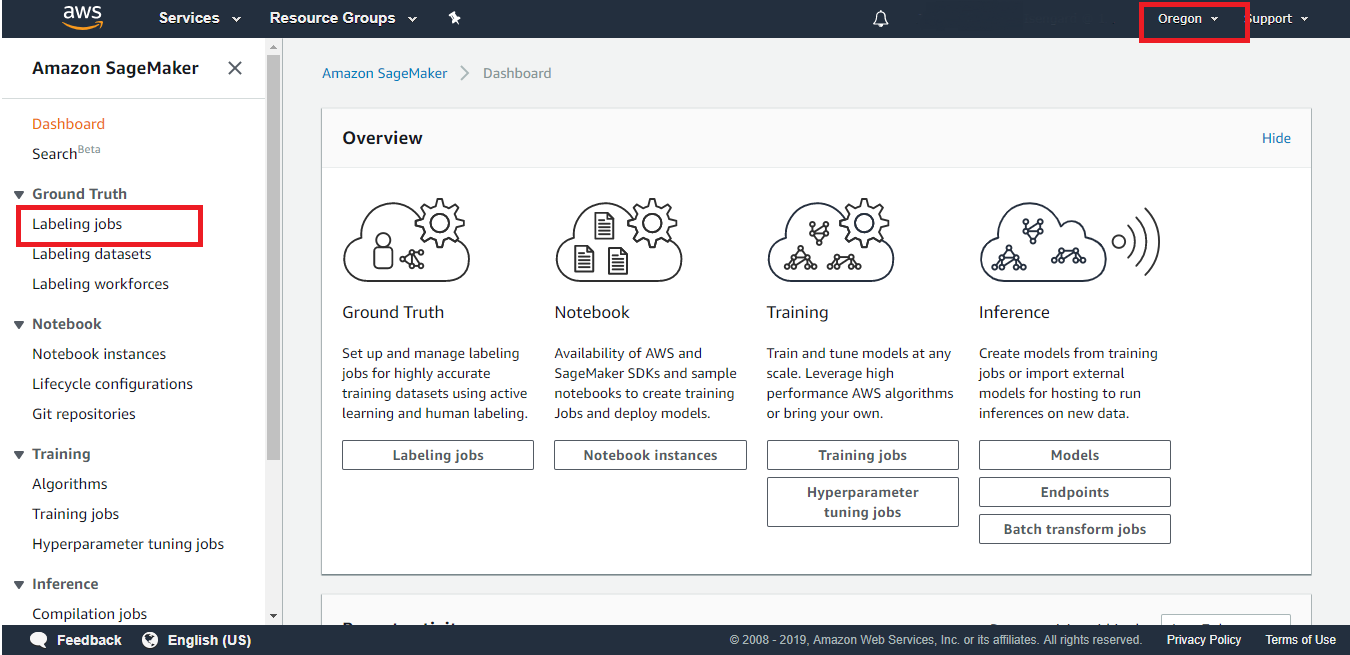

To kick off a Labeling, click the 'Create labeling job' button.



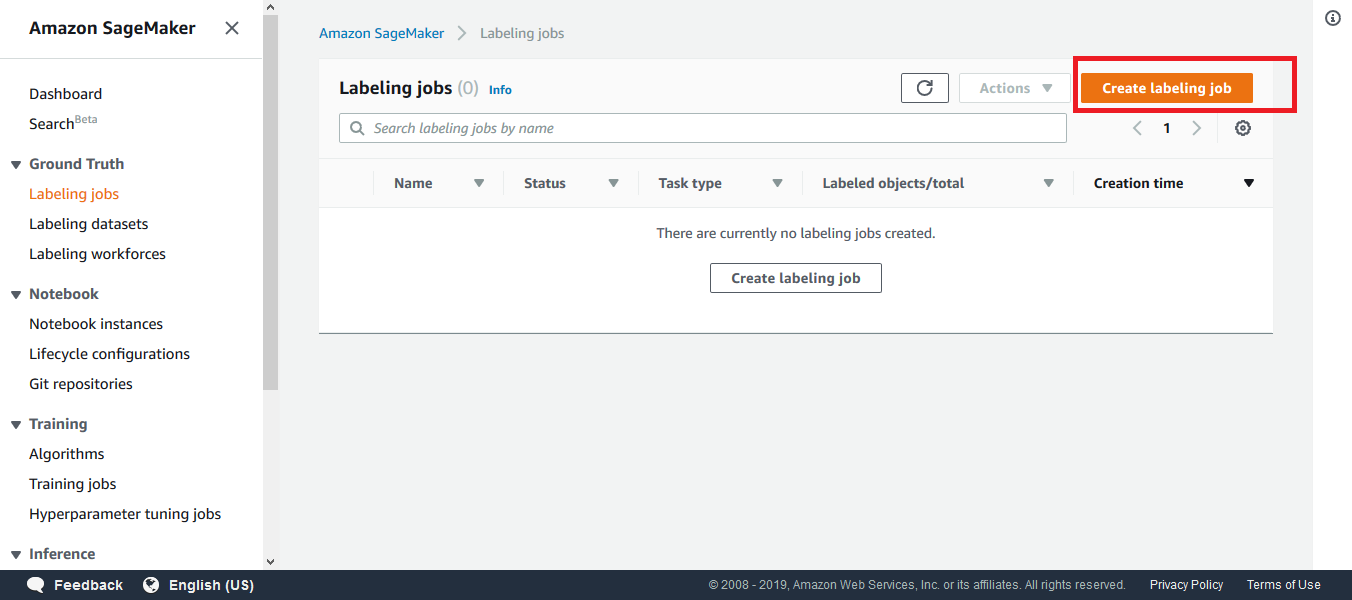



# Step 2: Set up input and output dataset locations

Let's begin by giving a name to the labeling job. Since this labeling job is only meant to be a sample, let's name it 'Sample-labeling-job'. 

Then, let's give the path to the input dataset location. A labeling job takes an input manifest as the input dataset. An input manifest effectively points to the dataset objects in the dataset.


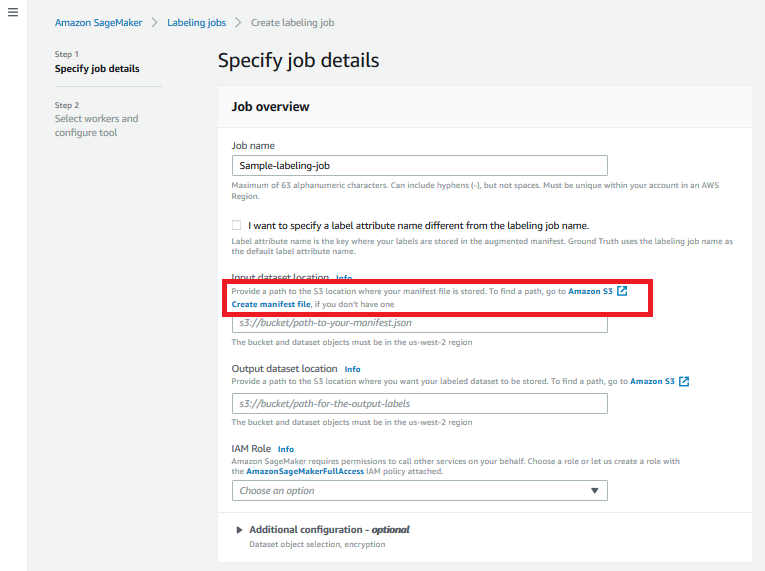


Realize that we have not yet created the input manifest. Instead above, we only uploaded 500 images. Fortunately, SageMaker Ground Truth provides a cool feature that creates the input manifest for you. 

To use this feature, click on the 'Create manifest file' link and provide the path to the uploaded images: s3://sagemaker-xxx/reinvent-artifacts/datasets/. Select 'Images' as the 'Data type' and then select 'Create' to kick off the process. Once the manifest creation process has completed, select 'Use this manifest'. 



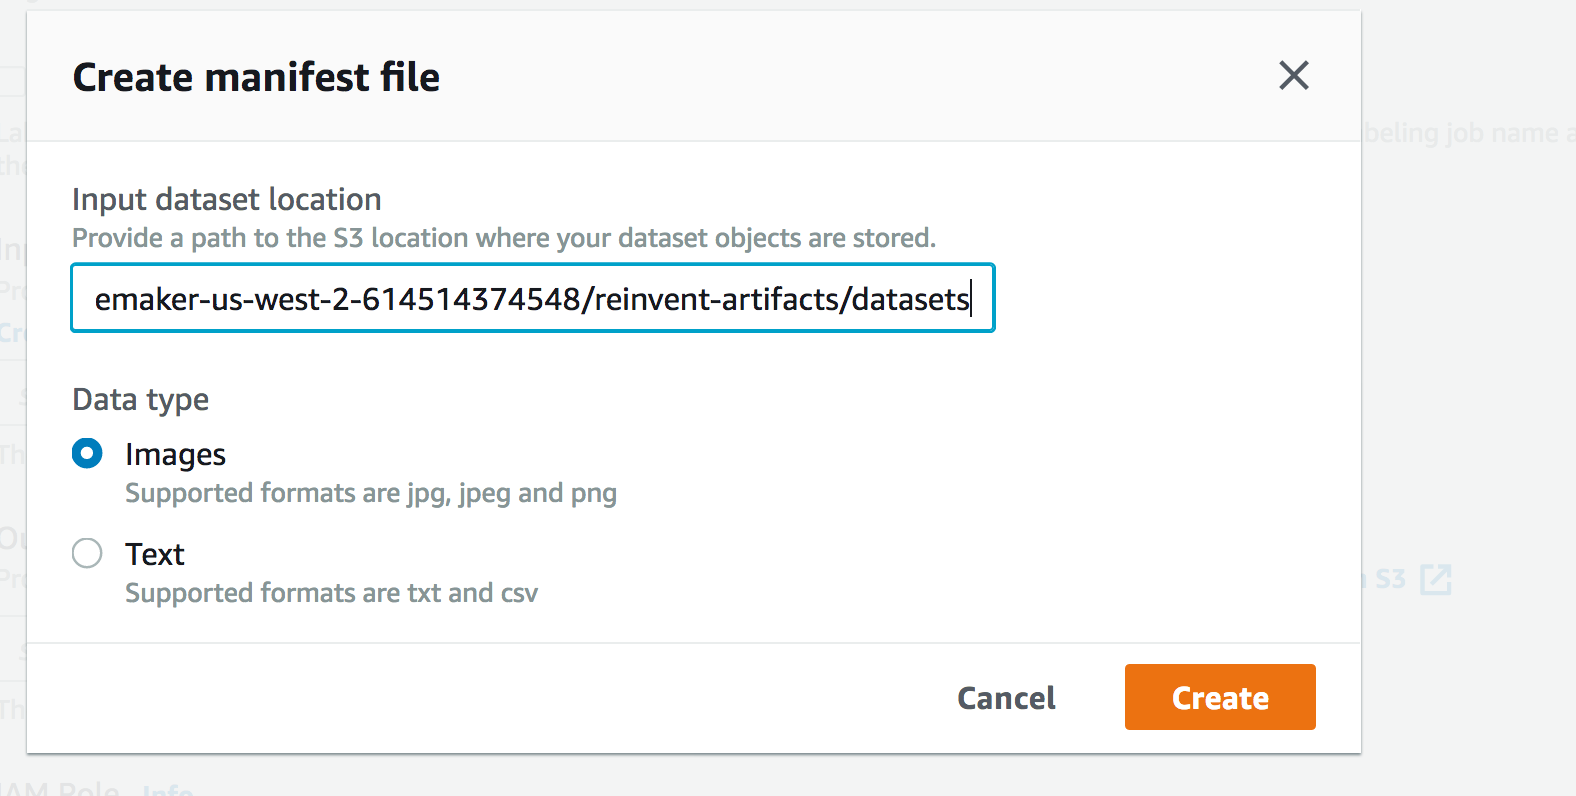

Make sure to click on the "Use this Manifest" button once the manifest has been created.



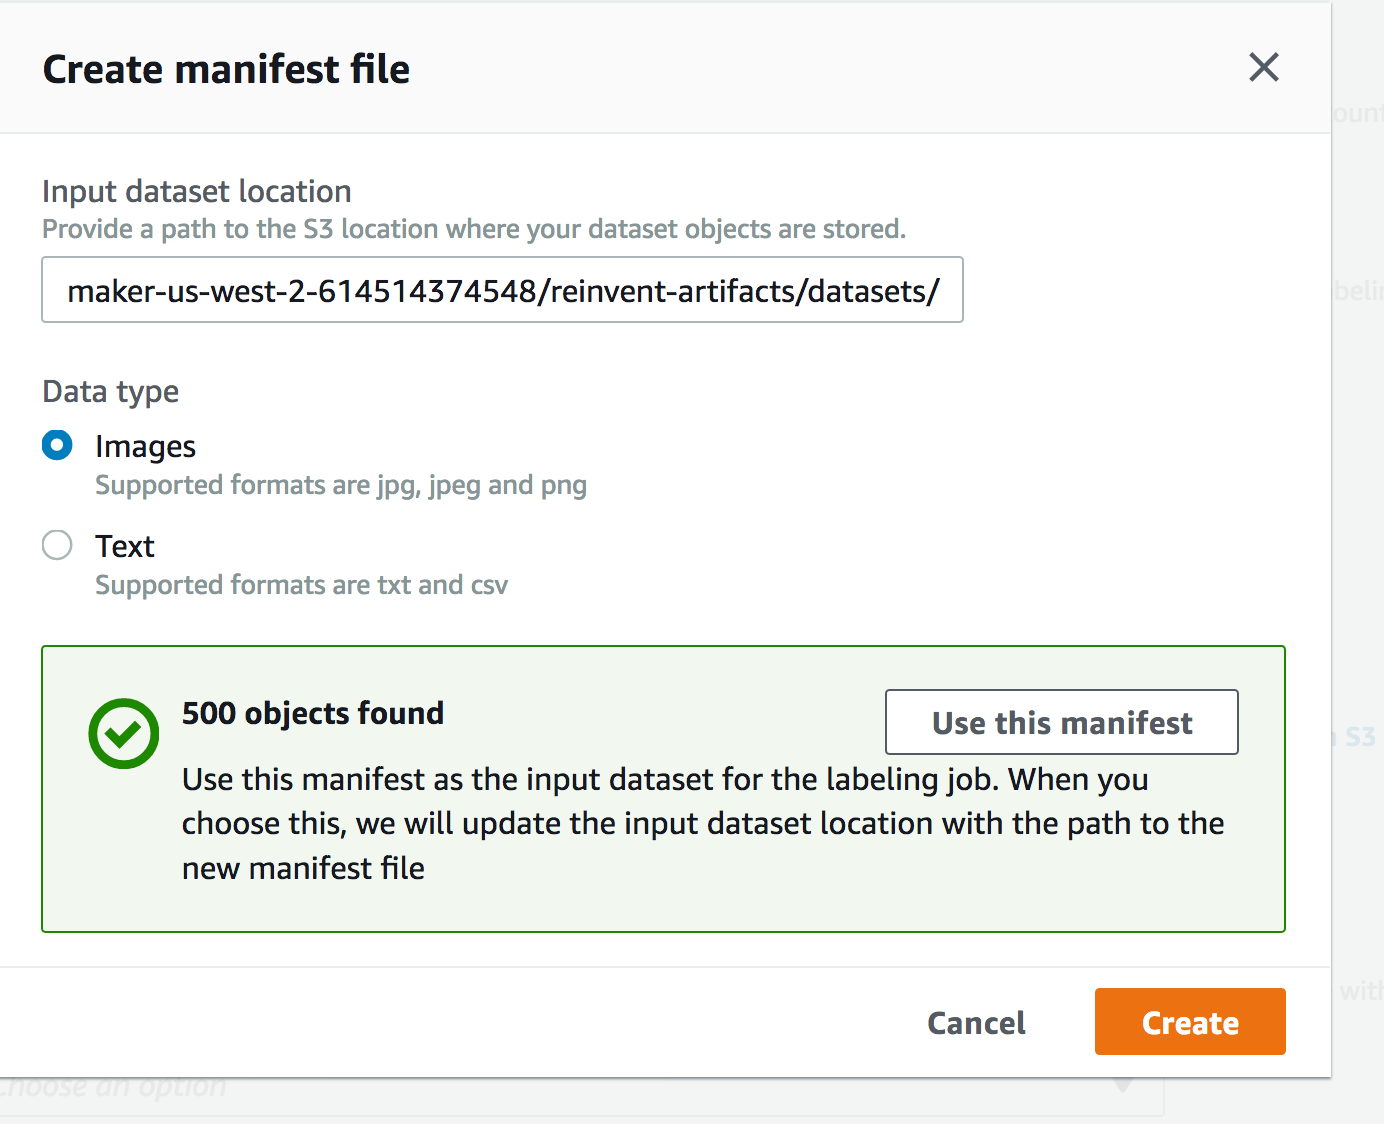



Next, let's fill out the output dataset location. This is the S3 location where SageMaker Ground Truth will output all of the  labels generated as well as any intermediate data. We will opt to simply point to the 'sagemaker-xxx-region' S3 bucket as the output location. 

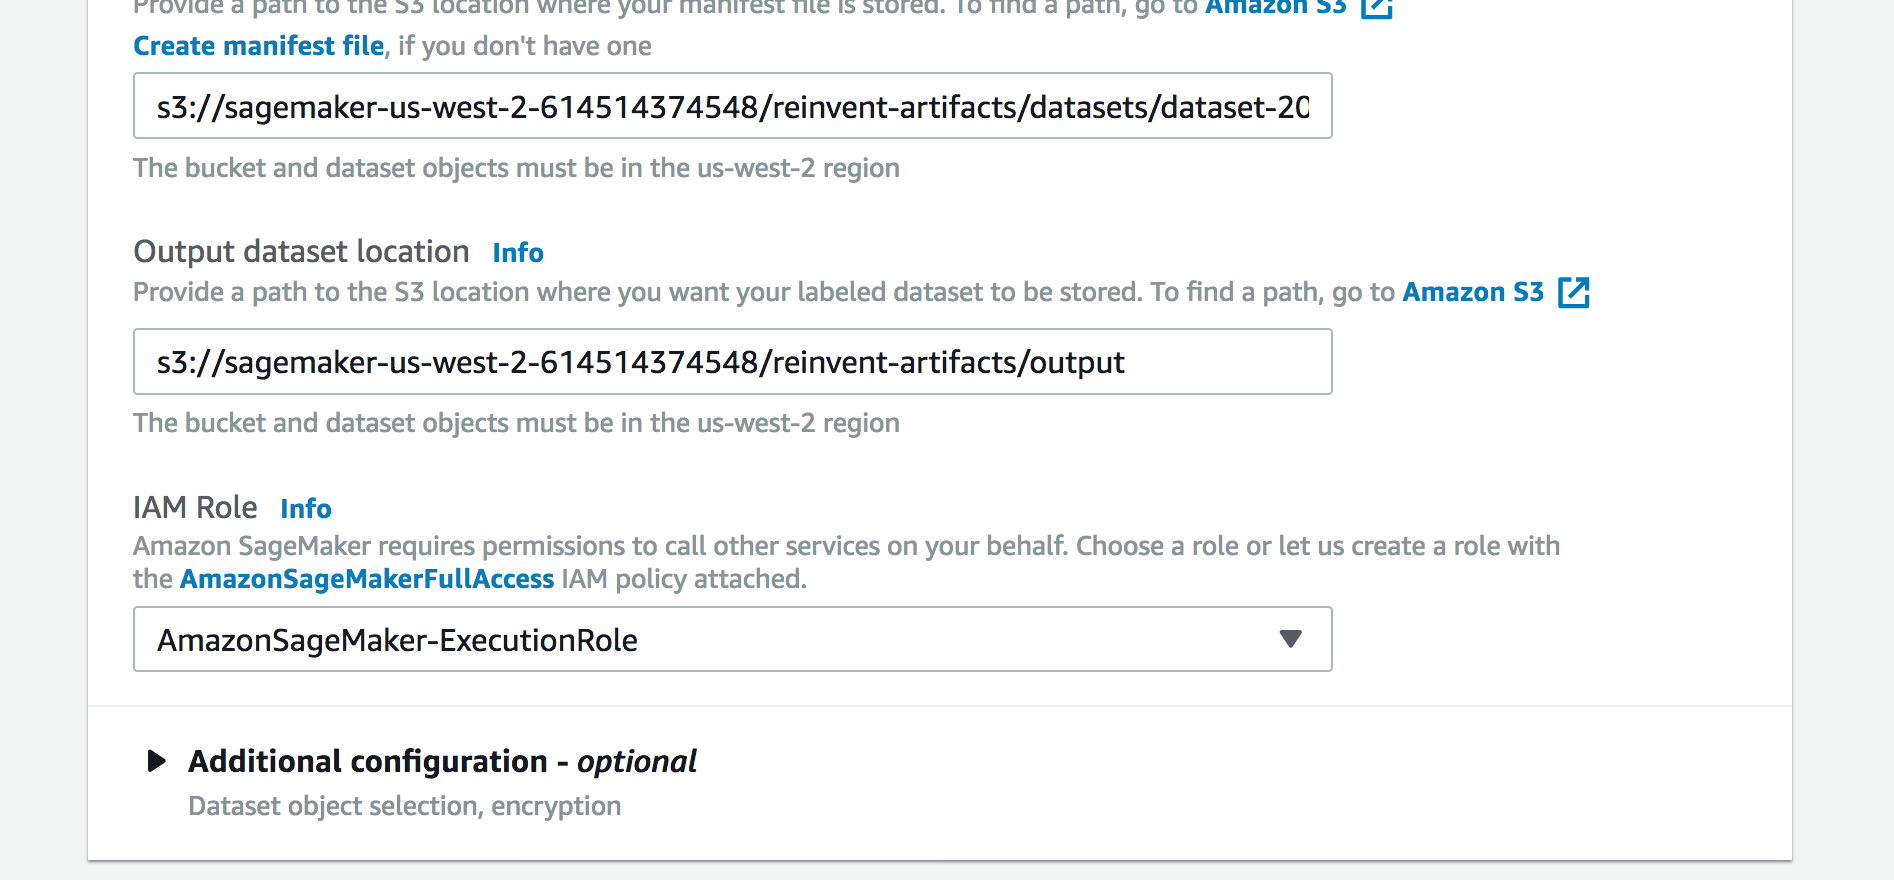

Then, we will provide the IAM Role that allows SageMaker Ground Truth to read and write to your S3 locations. The easiest option is 'Create a new role' and specifically provide access to the 'sagemaker-xxx-region' S3 bucket.


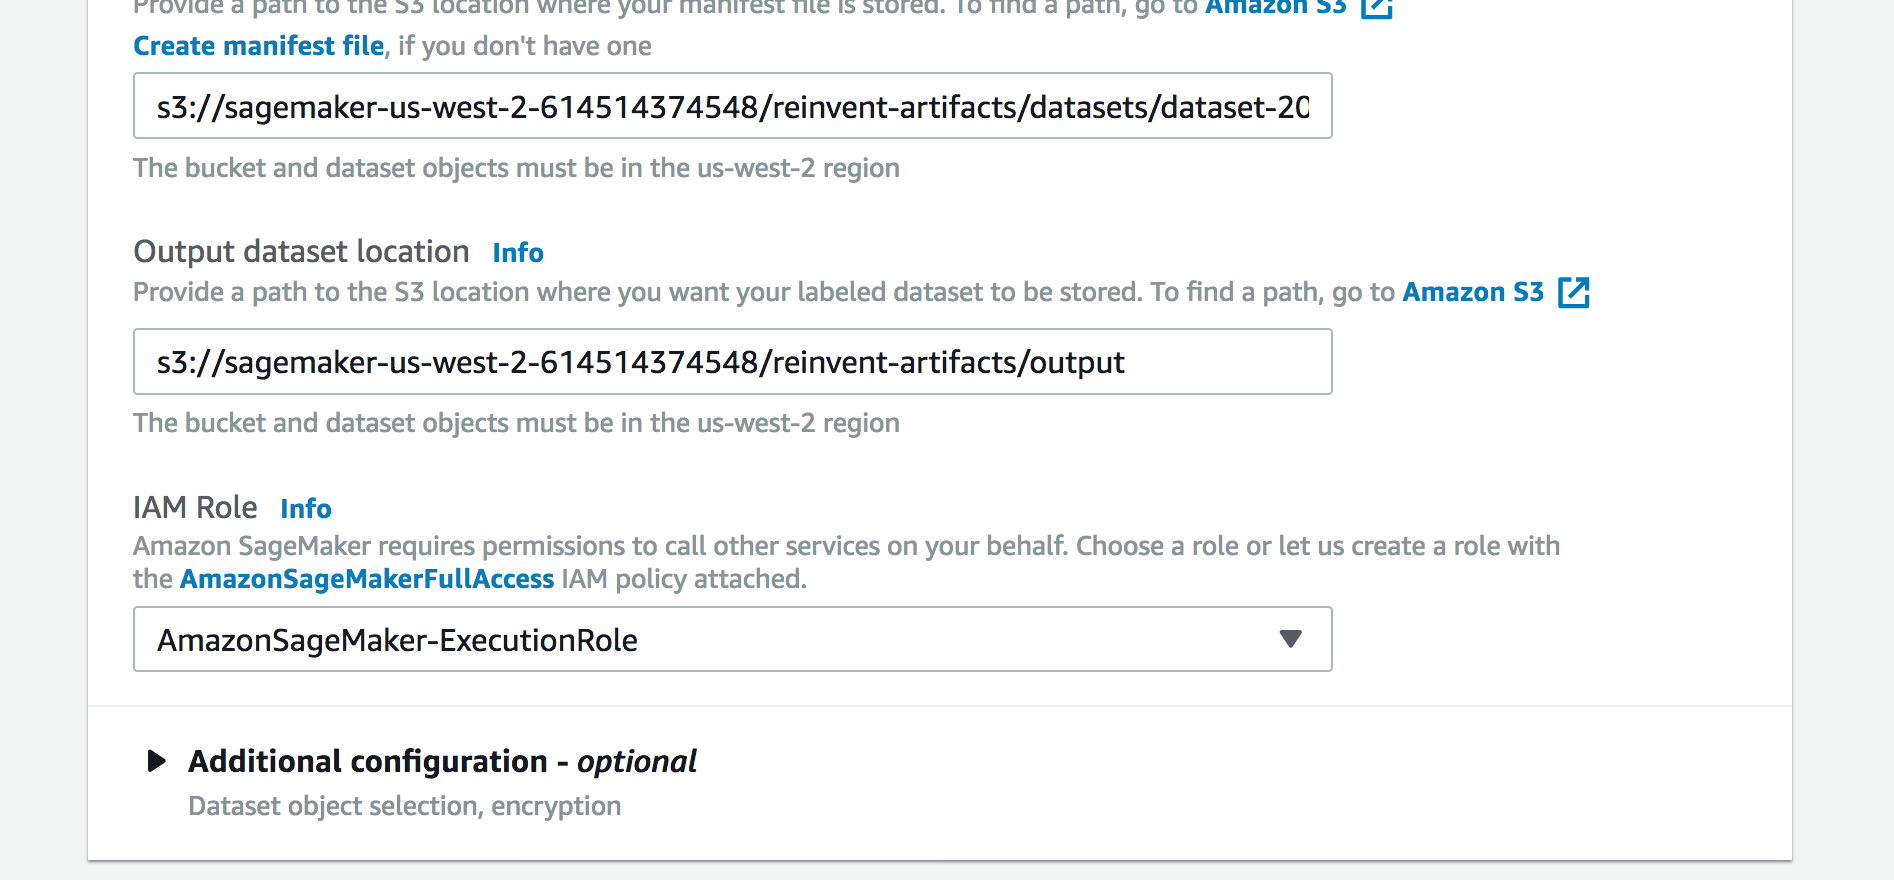



There are currently 500 images in our input dataset. We do not want to send all 500 images to the labeling job (for time and cost reasons). Instead, we want to randomly sample 2% of the images (or 10 images). SageMaker Ground Truth makes it easy to perform this sampling.

Click on 'Additional configuration', and click on the 'Random sample' option. Next, indicate you want to sample 2% of the dataset. Then to complete the process, click on 'Create subset'. This will create a new input manifest, and once it is created, click 'Use this subset'. 


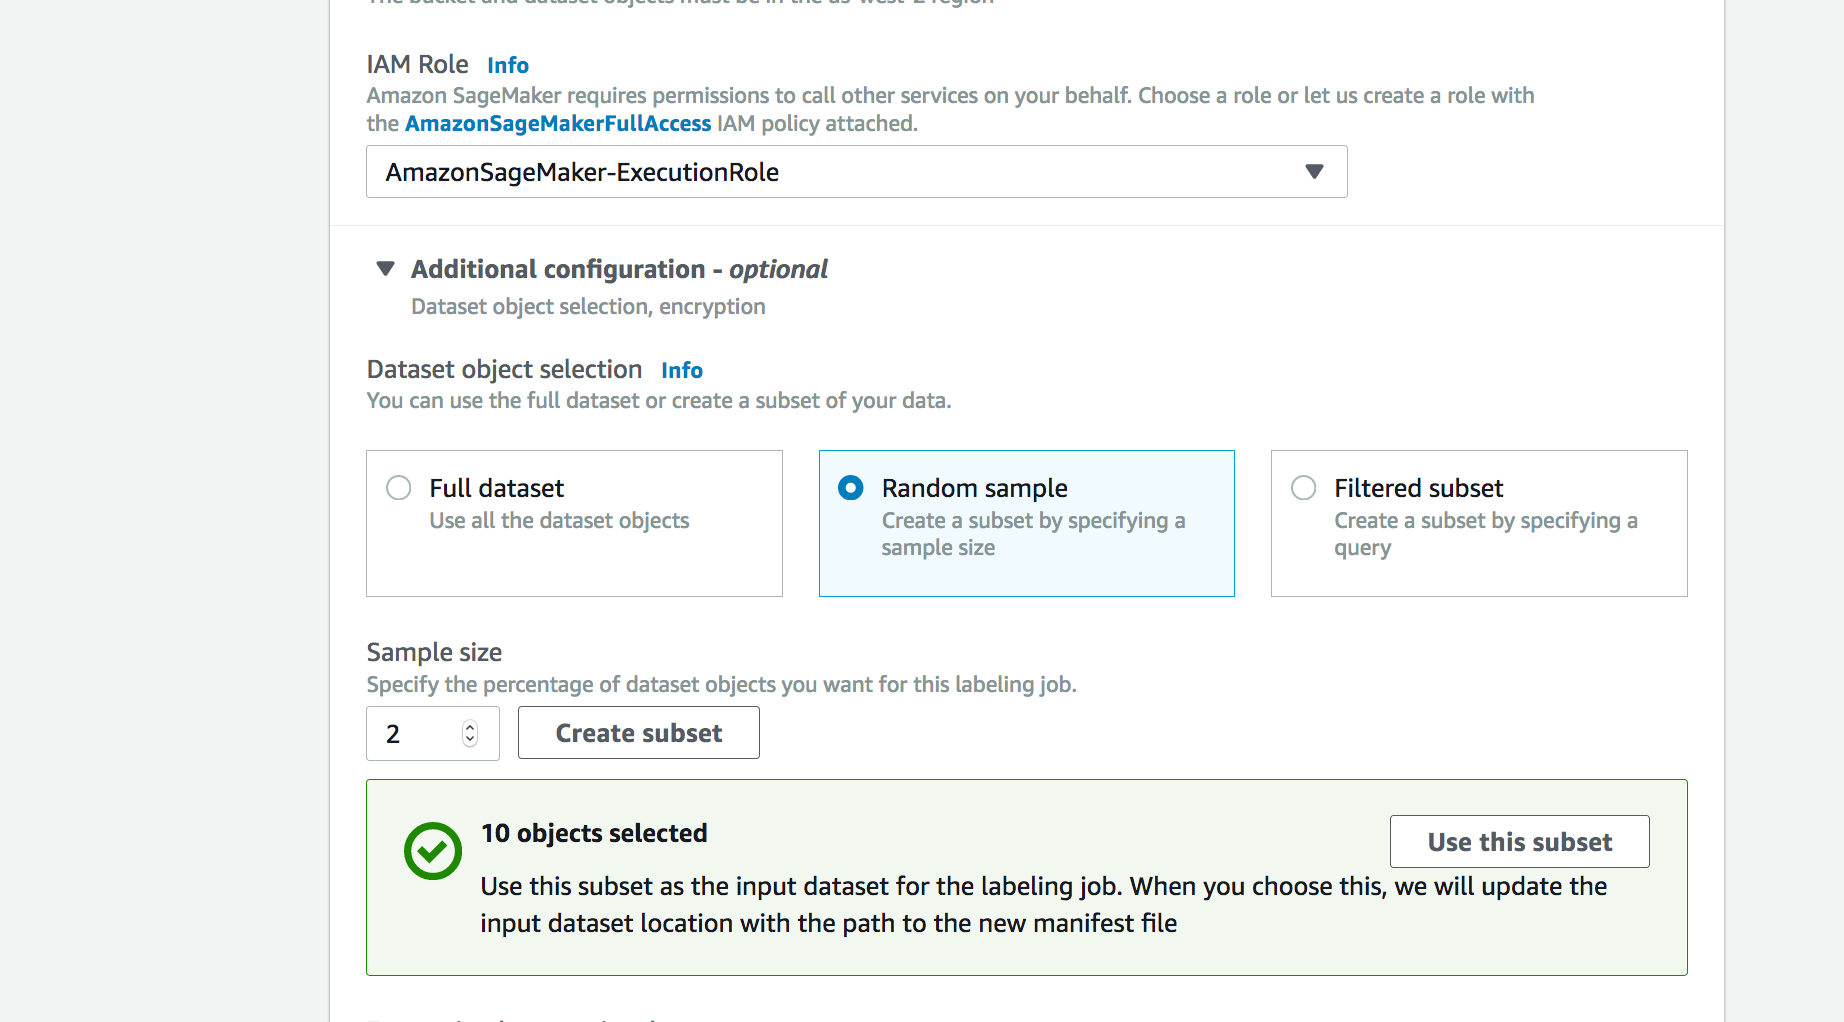

Make sure to click on the "Use this subset" button once the subset has been created.







### Step 3: Select task type and worker type

Under 'Task type', select the 'Bounding box' option. To complete this step, click 'Next' at the bottom of the page.

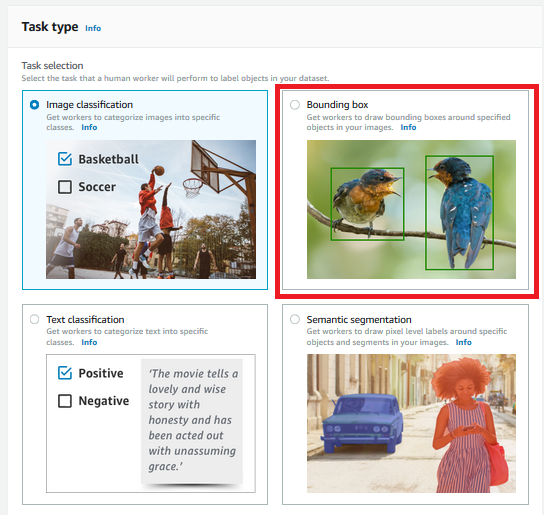

For this labeling job, we want to use the **'Private'** worker option. This option will direct the labeling job to an internally defined workforce. For the purposes of this workshop we will use our own contact details to set ourselves up as the workforce. 

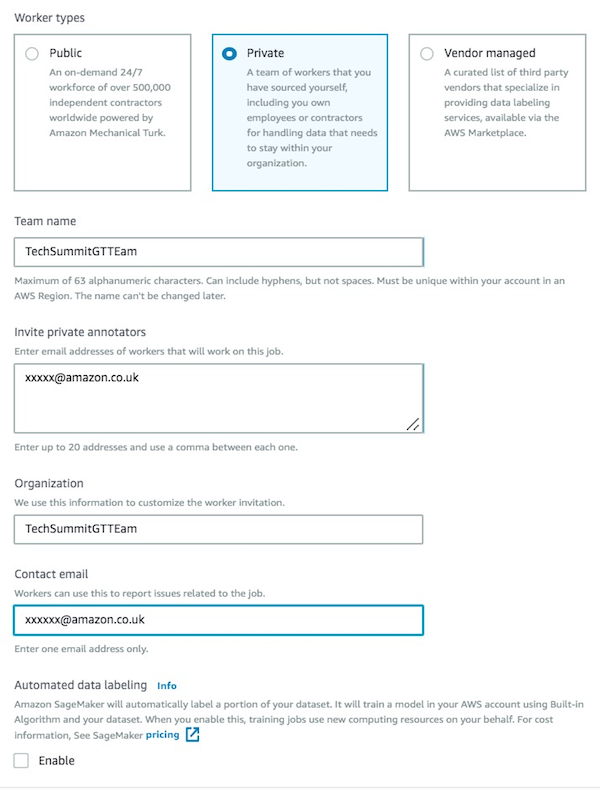

### Step 4: Create the task instructions

This is the most important step as it will directly impact the accuracy of the labels generated. We have discussed this topic in-depth in this blog post: https://aws.amazon.com/blogs/machine-learning/create-high-quality-instructions-for-amazon-sagemaker-ground-truth-labeling-jobs/

Start with your primary call-to-action in the header; here we use: "Draw a bounding box around the bee in this image." Then, let's define the label category on the right-hand side. This is "bee" in our case. 

Next, we want to provide visual examples of both good and bad labels. We have pre-created these examples, and you can directly insert these examples by clicking on the image icon and then pointing to the below public URLs:

Good Example - https://s3.us-west-2.amazonaws.com/sagemaker-remars/bee-good-5535715.jpg 

Bad Example - https://s3.us-west-2.amazonaws.com/sagemaker-remars/bee-bad-5535715.jpg

Then, we suggest providing some helper text to guide the workers for both good and bad examples. Once done select the "Preview" button if you like to view the page presented to the workers.

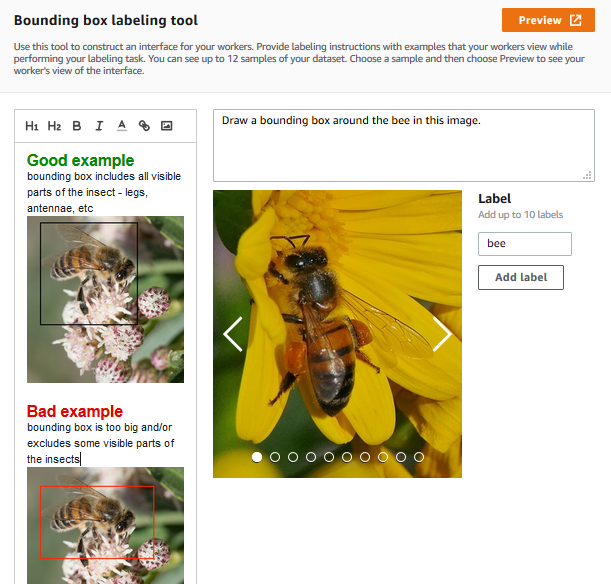


### Labeling

By now you should have received an email inviting you to log into the labeling UI. Click on the link provided and login - you will be asked to change your password. Once in, start labeling.

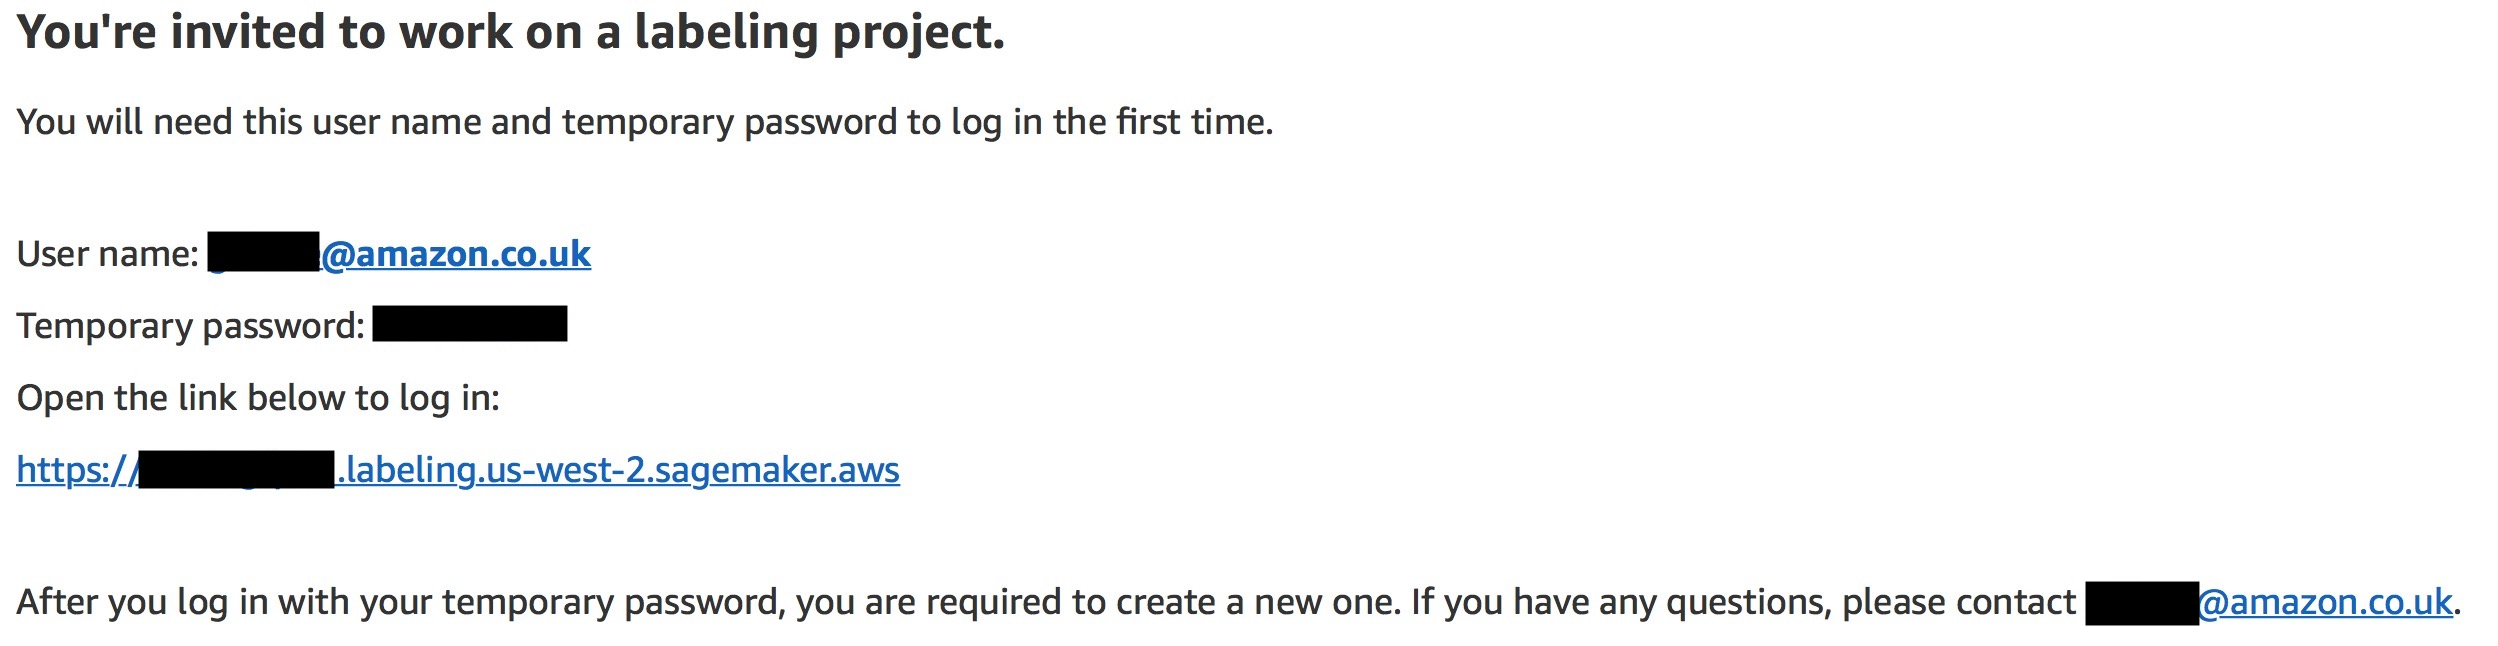

If instead of Private workforce you chose Public, the labeling will be performed by the Amazon Mechanical Turk public workforce, which is globally distributed, 24/7 available. With the public workforce it may take some time before all images are labeled even if it's a small subset.

## Reviewing labeling results
<a name="reviewing"></a>

**WARNING: Pick OPTION 1 or OPTION 2 cells below**

If your labeling job has not finished (in case you chose the Public workforce), we can review results of the previously completed labeling job called ```bees-500``` using the provided augmented manifest file ```output.manifest```. In that case run OPTION 1 cell below and skip OPTION 2. Otherwise, skip OPTION 1 and run OPTION 2 to use results of your own labeling job.

## Option 1: Provided labeling results

In [ ]:
###########
# OPTION 1: provided labeling results
###########

labeling_job_name = 'bees-500'
augmented_manifest_file = '/home/ec2-user/SageMaker/output/output.manifest'
augmented_manifest_file

## Option 2: Your own labeling job completed (Not Needed If You Will Use The Pre-Labeled Manifest)

In [ ]:
###########
# OPTION 2: your own labeling job completed
###########
# Enter the name of your job here
labeling_job_name = 'Sample-labeling-job'

import boto3
client = boto3.client('sagemaker')

s3_output_path = client.describe_labeling_job(LabelingJobName=labeling_job_name)['OutputConfig']['S3OutputPath'].rstrip('/')
augmented_manifest_url = f'{s3_output_path}/{labeling_job_name}/manifests/output/output.manifest'

import os
import shutil

try:
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')

# now download the augmented manifest file and display first 3 lines
!aws s3 cp $augmented_manifest_url od_output_data/
augmented_manifest_file = 'od_output_data/output.manifest'

## Explore the Manifest file

Let's see the first few lines of the manifest file. Each line in the file is a JSON object. Each JSON object contains a:

1- `source-ref`: key that points to the labeled file.

2- `human-annotated`: (yes or no). If no, it means that this specific image has been automatically annotated by Ground Truth.

3- `anotations`: which contains the class and the coordinates of the annotations because this is an Object Detection job.

4- `confidence`: This is the confidence score 

In [ ]:
!head -3 $augmented_manifest_file

## Visualize Labeling Results on Images

Now let's plot some of the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [ ]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle
import jsonlines
from itertools import islice


labeling_job_name = 'bees-500'

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    
with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        print(img_url)
        img_file = os.path.basename(img_url)
        img_file='/home/ec2-user/SageMaker/datasets/' + img_file
        bboxes = desc[labeling_job_name]['annotations']
        print(img_file)
        show_annotated_image(img_file, bboxes)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

For this, we would need to split the full labeled dataset into a training and a validation datasets. Out of the total of 500 images we are going to use 400 for training and 100 for validation. The algorithm will use the first one to train the model and the latter to estimate the accuracy of the model, trained so far. The augmented manifest file from the previously run full labeling job was included in the original zip archive as `output.manifest`.

In [ ]:
import json

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = '/home/ec2-user/SageMaker/train.manifest'
augmented_manifest_filename_train_file ='train.manifest'


with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = '/home/ec2-user/SageMaker/validation.manifest'
augmented_manifest_filename_validation_file= 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')



## Upload the annotated dataset to S3 Bucket

Next, let's upload the two manifest files to S3 in preparation for training. We will use the same bucket you created earlier.

In [ ]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train_file)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation_file)
print(s3_train_data_path )

!aws s3 cp /home/ec2-user/SageMaker/train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp /home/ec2-user/SageMaker/validation.manifest s3://$BUCKET/$pfx_training/
print("Dataset Upload Completed ...")

## Specify the Training Job Name:

In [ ]:
training_job_name = 'ObjectDetectionTraining9'

## Start the Training Job Programmatically

In [ ]:
import time
import sagemaker

import boto3
client = boto3.client('sagemaker')

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, 'object-detection', repo_version='latest')
s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)

s3_train_data_path = 's3://{}/{}/train.manifest'.format(BUCKET, pfx_training)
s3_validation_data_path = 's3://{}/{}/validation.manifest'.format(BUCKET, pfx_training)

# Checking if the training job name is specified
assert training_job_name,"Please Specify a training job name"


training_params = \
    {
        "AlgorithmSpecification": {
            # NB. This is one of the named constants defined in the first cell.
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "early_stopping": "true",
            "early_stopping_min_epochs": "20",
            "early_stopping_patience": "20",
            "early_stopping_tolerance": "0.0",
            "num_classes": "1",
            "mini_batch_size": "11",
            "epochs": "100",
            "learning_rate": "0.0009584934211859066",
            "lr_scheduler_factor": "0.1",
            "optimizer": "rmsprop",
            "momentum": "0.5344887033599255",
            "weight_decay": "0.0014518939447042232",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "500",
            "num_training_samples": "500"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', 'bees-500']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', 'bees-500']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
    }

# Now we create the SageMaker training job.
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

## Check the training Progress

To check the progess of the training job, you can refresh the console or repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [ ]:
import boto3
from time import sleep
client = boto3.client('sagemaker')

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])
client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)

## Attach The Training Job and Check the Training Logs

In [ ]:
from io import StringIO  # Python3
import sys
result = StringIO()
sys.stdout = result

output = sagemaker.estimator.Estimator.attach(training_job_name, sagemaker.Session())
decoded_string = bytes(result.getvalue(), "utf-8").decode("unicode_escape")
output = decoded_string.split("\n")
    
results = [metric[metric.find('validation mAP'):-4] for metric in output if "mAP" in metric and metric[metric.find('validation mAP'):-4] is not '']
results

<a name='review_training'></a>

## Deploying the Model and Making Predictions

First, let's create the SageMaker model out of model artifacts

In [ ]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

## Create an Endpoint Configuration and host size

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

## Perform inference

We will invoke the deployed endpoint to detect bees in the 10 test images that were inside the `test` folder in `dataset.zip` which you downloaded at the beginning of the workshop.

### List of Test Images

In [ ]:
import glob
test_images = glob.glob('/home/ec2-user/SageMaker/test_images/*')
print(*test_images, sep="\n")

### A Function to Draw Bounding Boxes

Next, define a function that converts the prediction array returned by our endpoint to the bounding box structure expected by our image display function.

In [ ]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

### Inference and Predictions

Finally, for each of the test images, the following cell transforms the image into the appropriate format for realtime prediction, repeatedly calls the endpoint, receives back the prediction, and displays the result.

In [ ]:
import matplotlib.pyplot as plt


runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .4
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

<a name='model_tuning'></a>
## Model Tuning - HyperParameters Optimization

When you configured the training job you needed to add many hyperparameters that affect the performance of the algorithm and the quality of the resulting model. But how do you pick the right hyperparameters?

If you have experience with the specific algorithm and understand the innerworkings of it, you may already have a good sense of appropriate values. But even then, it's impossible to know the exact best value of each hyperparameter. Often you can zero in on the best values by trying many different combination of values, effectively searching in the hyperparameter space. SageMaker makes this extremely easy with the Model Tuning feature, also known as Hyperparameter Optimization (or HPO). With Model Tuning you simply decide which of the hyperparameters you are not sure about and specify the range of values for each that SageMaker needs to explore. Let's see again how this can be accomplished via the console.

#### Step 1: SageMaker Training Job wizard

First, click on the "Training Jobs" link in the SageMaker Nav bar.

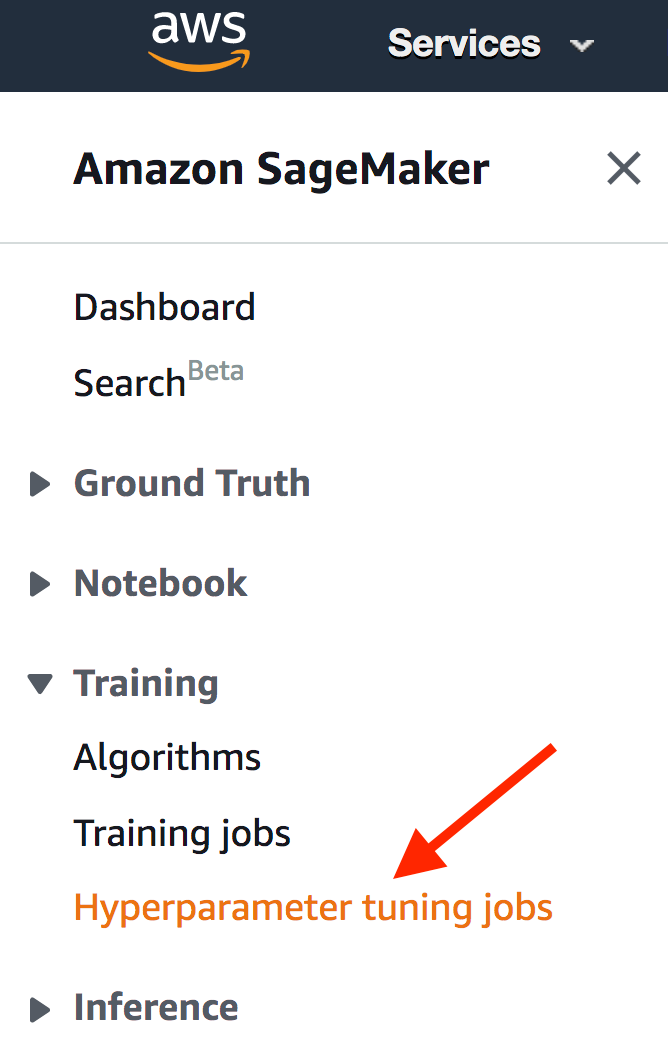

Then, click on "Create hyperparameter tuning job" button.

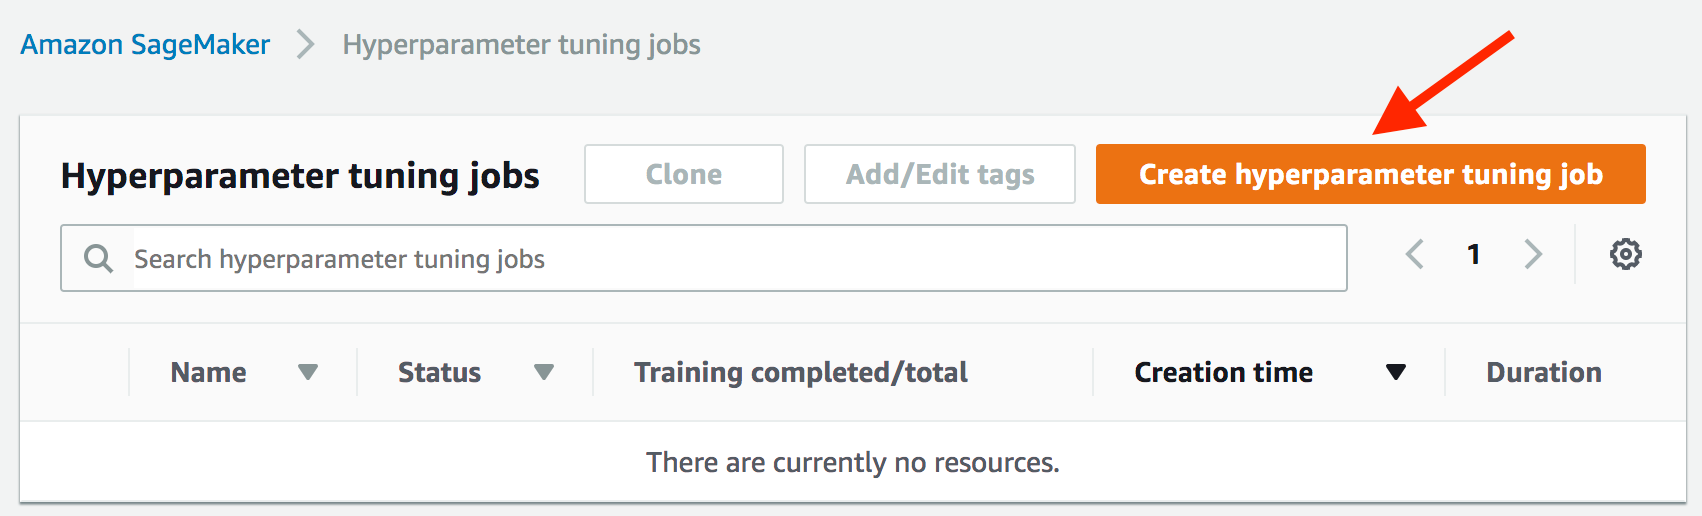

#### Step 2: SageMaker Hyperparameter Tuning Job wizard: objective metric

You have now entered the Hyperparameter Tuning Job wizard and for the most part you would need to make the same selections as you did when you created the training job or leave default selections. When you get to selecting the so-called `objective metric` you want to make the following choices:


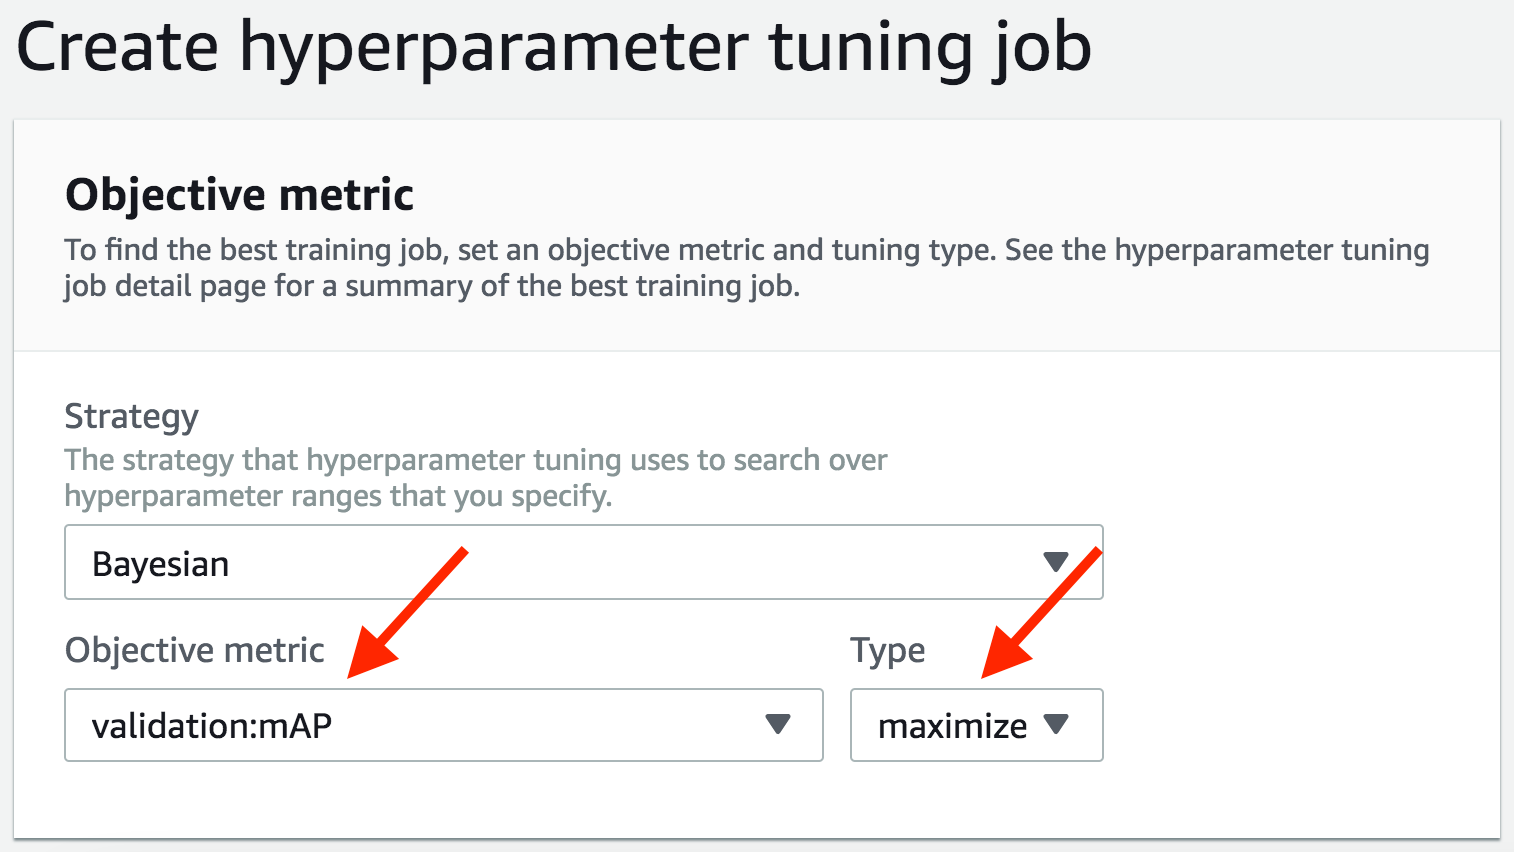


#### Step 3: SageMaker Hyperparameter Tuning Job wizard: hyperparameter ranges

Next, we need to tell SageMaker which hyperparameters we are fixing (leaving `Static`) and which we'd like to optimize. Here is the [relevant documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-tuning.html) for the Object Detection algorithm. For this exercise, we will be optimizing `learning_rate`, `mini_batch_size` and `optimizer`, and leave the others `Static`.


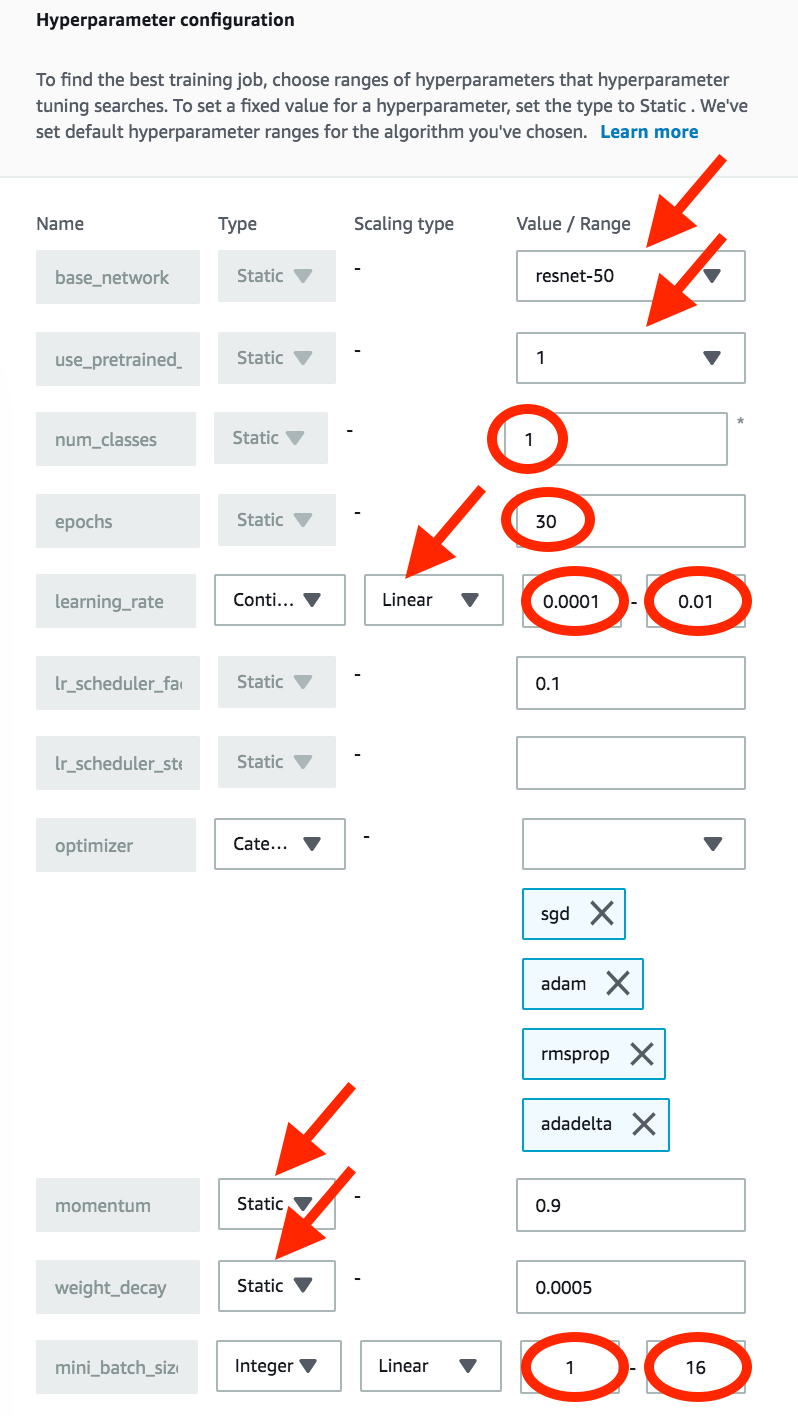

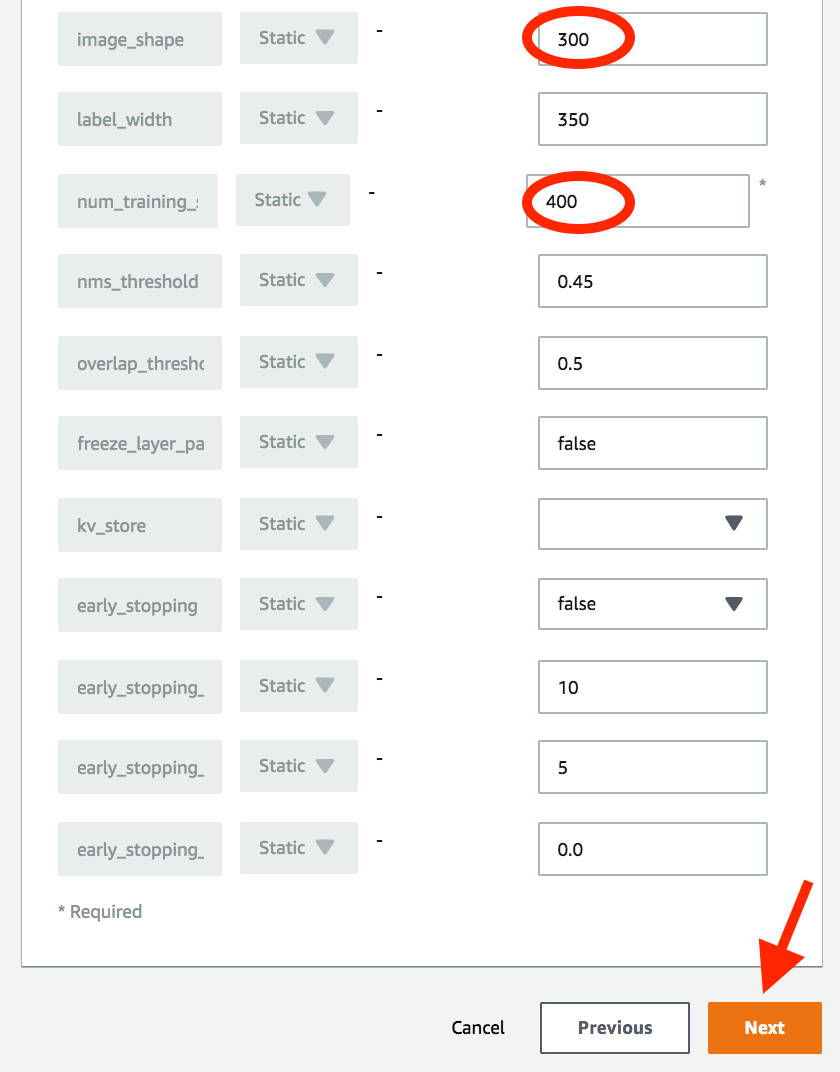





#### Step 4: SageMaker Hyperparameter Tuning Job wizard: Input and Output locations

Next, specify the training/validation data sources and output location - all with the same values as regular training.

#### Step 5: SageMaker Hyperparameter Tuning Job wizard: Resource configuration and limits

And now, specify the instance type for each training job (same `p2.xlarge` works), number of instances each training job is going to run on and, finally, the limit on how many training jobs will be run in total (this is a way to control the costs) as well as the limit on how many parallel jobs you can run. The latter parameter controls how many instances will be used concurrently at any one time. So 1 instance per training job with 3 parallel jobs maximum would mean at most 3 `p2.xlarge` instances being used concurrently while the hyperparameter tuning job is running.


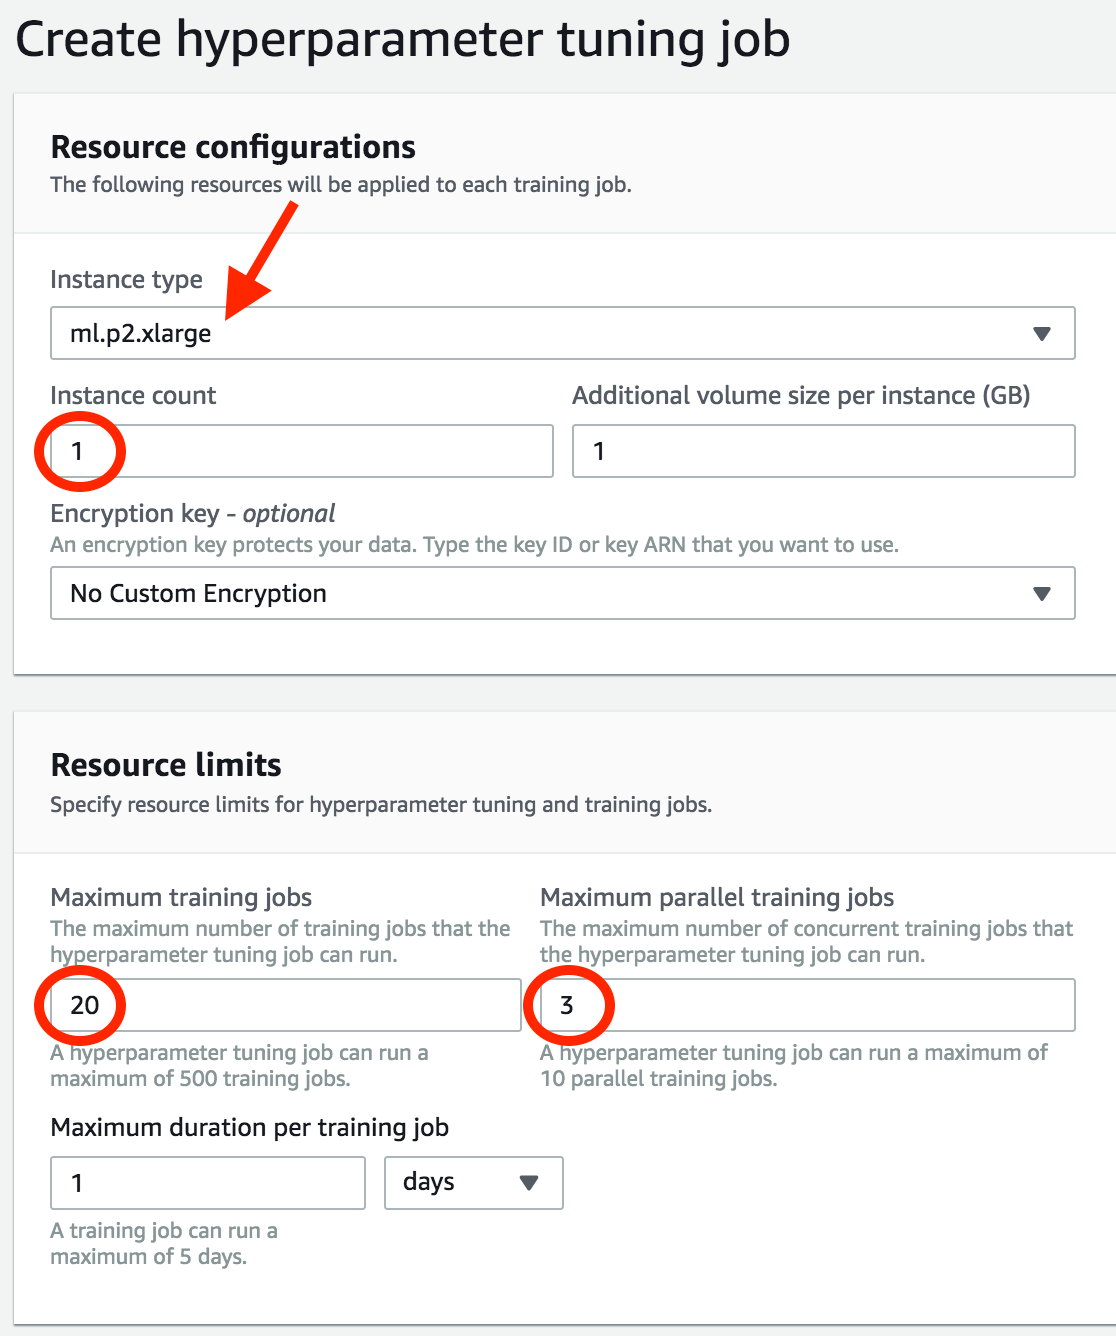

Finally, just press the `Create job` button to kick off training. Once the HPO jobs are all finished, you can use the console to find the one job that resulted in the best (highest) value for `validation:mAP`. You can then use the model artifacts as previously described when we trained the first model (without HPO), and deploy them to an endpoint to verify the results.


<a name='cleanup'></a>
## Cleanup

At the end of the lab we would like to delete the real-time endpoint, as keeping a real-time endpoint around while being idle is costly and wasteful. 

In [ ]:
#client.delete_endpoint(EndpointName=endpoint_name)